# Reading and interpreting the DES Y1 power spectra
This example shows how to read and interpret the DES Y1 SACC files, including:
- How to read a SACC file.
- How to implement basic cuts (scales, data types) on the data.
- How to put together a joint data vector and covariance matrix.
- How to access tracer information.
- How to interpret the data vector and create a theory prediction for it fully accounting for mode coupling.
- How to access and use the $B$-mode null tests.

In [1]:
import sacc
import numpy as np
import pyccl as ccl
import os
import matplotlib.pyplot as plt

## Reading the data and cleaning them up
Let's start by downloading the data if we don't have them yet.

In [2]:
if not os.path.isfile('cls_signal_covG_ns4096.fits'):
    import wget
    wget.download('https://entangled.physics.ox.ac.uk/index.php/s/Dxxu7NvtTo2JaUt/download')
    wget.download('https://entangled.physics.ox.ac.uk/index.php/s/lBIJPzwkcWhXQv0/download')
    wget.download('https://entangled.physics.ox.ac.uk/index.php/s/gSxY7Q3P4SJrgDW/download')

Now let's read the signal file. With `SACC` it's as simple as:

In [3]:
s = sacc.Sacc.load_fits('cls_signal_covG_ns4096.fits')

/home/alonso/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


OK, the raw file contains all correlations between the $E$ and $B$ components of the shear field for the four redshift bins in the DES Y1 release, up to $\ell\sim12,000$. Let's focus on the $E$-modes, since they contain the only observable signal. Additionally, let's remove all small scales ($\ell>2,000$) to avoid issues with baryonic effects and other nasty things.

In [4]:
# Remove all B-mode contributions
s.remove_selection(data_type='cl_eb')
s.remove_selection(data_type='cl_be')
s.remove_selection(data_type='cl_bb')
# And now all ells > 2000
s.remove_selection(ell__gt=2000)

The full data vector and its covariance can be retrieved as:

In [5]:
d = s.mean
cov = s.covariance.covmat
print(d.shape, cov.shape)

(250,) (250, 250)


OK, great! We have 250 usable, clean datapoints. Now what?

## Tracers
In order to generate a theory prediction for these data we need to know the redshift distribution of the 4 redshift bins. These are stored in the SACC files as `Tracer`s. You can access them as follows:

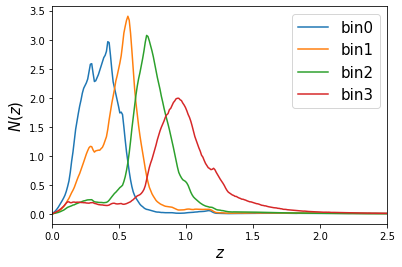

In [6]:
plt.figure()
for i_t, (n, t) in enumerate(s.tracers.items()):
    plt.plot(t.z, t.nz, label=n)
plt.xlim([0, 2.5])
plt.xlabel(r'$z$', fontsize=15)
plt.ylabel(r'$N(z)$', fontsize=15)
plt.legend(fontsize=15)
plt.show()

The tracers also store the exact edges of the redshift intervals over which the redshift distributions are defined. You can access them as:

In [7]:
z_ini = s.tracers['bin0'].extra_columns['z_i']
z_end = s.tracers['bin0'].extra_columns['z_f']
print(np.unique(z_end-z_ini))
# As you can see they're all spaced by ~0.01.

[0.01 0.01 0.01 0.01 0.01 0.01 0.01]


## Building a theory prediction
Let's now build a theory prediction for this data vector. For this we will use [CCL](https://github.com/LSSTDESC/CCL/pulls). We start by creating CCL `Tracer`s for each SACC `Tracer`, which we will then combine to calculate power spectra.

We will do this for a standard $\Lambda$CDM cosmology.

In [8]:
# Generate cosmology
cosmo = ccl.Cosmology(Omega_c=0.260-0.0479,
                      Omega_b=0.0479,
                      h=0.685,
                      n_s=0.973,
                      sigma8=0.821)

# Create CCL Tracers
ccl_tracers = {n:ccl.WeakLensingTracer(cosmo, (t.z, t.nz))
              for n, t in s.tracers.items()}

In order to fully account for the effects of mode-coupling and binning, we need to compute the power spectrum at all $\ell$s and then convolve it with the bandpower window functions. Because the lensing power spectrum is kind of featureless, really computing it at all $\ell$s is kind of overkill, so instead we will compute it at a logarithmically sampled set of ells and then interpolate between them. The function below does that for any pair of bins.

In [9]:
from scipy.interpolate import interp1d

def get_cl(ls, n1, n2):
    ls_nodes = np.unique(np.geomspace(2, ls[-1], 30).astype(int)).astype(float)
    cls_nodes = ccl.angular_cl(cosmo,
                               ccl_tracers[n1],
                               ccl_tracers[n2],
                               ls_nodes)
    cli = interp1d(np.log(ls_nodes), cls_nodes,
                   fill_value=0, bounds_error=False)
    msk = ls >= 2
    cls = np.zeros(len(ls))
    cls[msk] = cli(np.log(ls[msk]))
    return cls

All ready. Now let's loop through all bin combinations (for which SACC has a nice wrapper function), calculate the theory prediction and assign it to the right part of the theory vector.

In [10]:
th = np.zeros_like(d)
for n1, n2 in s.get_tracer_combinations():
    # Get the indices for this part of the data vector
    ind = s.indices(data_type='cl_ee',
                    tracers=(n1, n2))
    # Get the bandpower window function.
    # w.values contains the values of ell at which
    # it is sampled
    w = s.get_bandpower_windows(ind)
    # Unbinned power spectrum.
    cl_unbinned = get_cl(w.values, n1, n2)
    # Convolved with window functions.
    cl_binned = np.dot(w.weight.T, cl_unbinned)
    # Assign to theory vector.
    th[ind] = cl_binned

Alright! Now let's plot this.

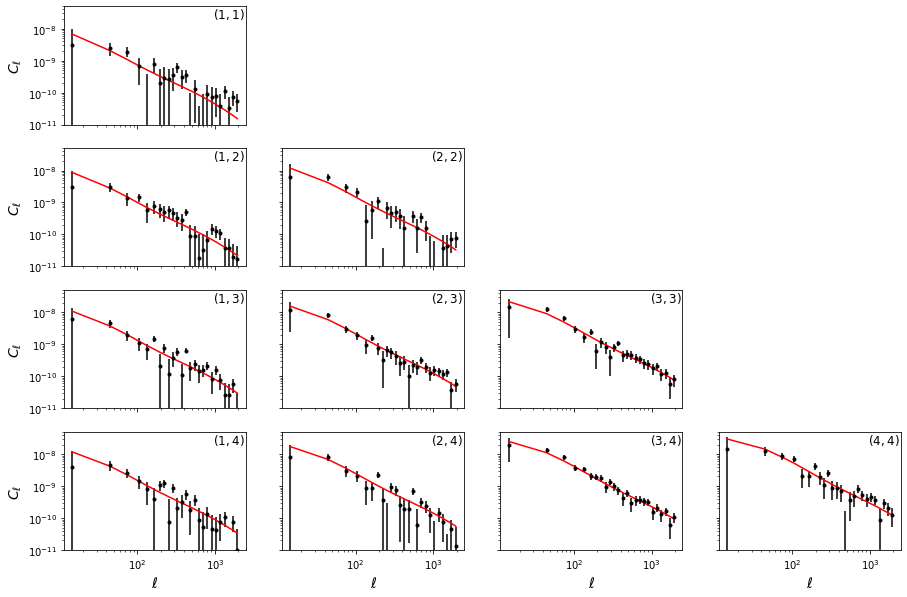

In [11]:
def get_triangle_axes():
    nbins=4
    fig, axes = plt.subplots(nbins, nbins,
                             figsize=(15, 10),
                             sharex=True,
                             sharey=True)
    for b1 in range(nbins) :
        for b2 in range(nbins) :
            if b2<b1 :
                axes[b2,b1].axis('off')
    return axes

axes = get_triangle_axes()
errors = np.sqrt(np.diag(cov))
for n1, n2 in s.get_tracer_combinations():
    i1 = int(n1[-1])
    i2 = int(n2[-1])
    ax = axes[i2, i1]
    ind = s.indices(data_type='cl_ee',
                    tracers=(n1, n2))
    ell = s.get_tag('ell', data_type='cl_ee',
                    tracers=(n1, n2))
    dl = d[ind]
    el = errors[ind]
    tl = th[ind]
    ax.errorbar(ell, dl, yerr=el, fmt='k.')
    ax.plot(ell, tl, 'r-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1E-11, 5E-8])
    ax.text(0.82, 0.9, f'$({i1+1},{i2+1})$',
            transform=ax.transAxes, fontsize=12)
    if i2 == 3:
        ax.set_xlabel(r'$\ell$', fontsize=14)
    if i1 == 0:
        ax.set_ylabel(r'$C_\ell$', fontsize=14)
plt.show()

This looks like a pretty good fit, right? Let's check the $\chi^2$ and its $p$-value.

In [12]:
import scipy.stats as stats
chi2 = np.dot(d-th, np.linalg.solve(cov, d-th))
ndof = len(d)
p = 1 - stats.chi2.cdf(chi2, ndof)
print("chi^2 = %.1lf, dof = %d, P = %.3lf" % (chi2, ndof, p))

chi^2 = 261.9, dof = 250, P = 0.291


How satisfying is that?!

## Noise and non-Gaussian covariance
We provide estimates of the noise bias and the non-Gaussian covariance in a separate SACC file. Things are stored just the same way. Let's inspect this file and redo some of our calculations above using it.

We start by reading in the file and performing the same cuts.

In [13]:
s2 = sacc.Sacc.load_fits('cls_noise_covNG_ns4096.fits')
s2.remove_selection(data_type='cl_eb')
s2.remove_selection(data_type='cl_be')
s2.remove_selection(data_type='cl_bb')
s2.remove_selection(ell__gt=2000)
# Let's check that the data has the same size now
assert len(s2.mean) == len(s.mean)

The full covariance is the sum of the Gaussian and non-Gaussian parts. Let's check them out:

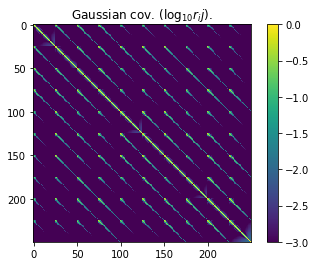

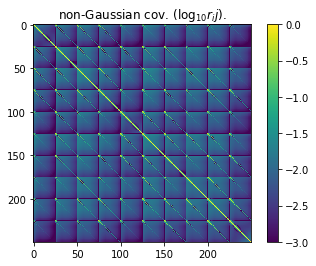

In [14]:
cov_full = cov + s2.covariance.covmat


def get_r(cv):
    cv_d = np.diag(cv)
    return cv / np.sqrt(cv_d[:, None] * cv_d[None, :])


from matplotlib.colors import LogNorm

plt.figure()
plt.title(r'Gaussian cov. ($\log_{10} r_ij$).')
plt.imshow(np.log10(np.fabs(get_r(cov))), vmin=-3, vmax=0)
plt.colorbar()

plt.figure()
plt.title(r'non-Gaussian cov. ($\log_{10} r_ij$).')
plt.imshow(np.log10(np.fabs(get_r(cov_full))), vmin=-3, vmax=0)
plt.colorbar()

plt.show()

Does the chi^2 change much after accounting for the non-Gaussian covariance?

In [15]:
chi2 = np.dot(d-th, np.linalg.solve(cov_full, d-th))
ndof = len(d)
p = 1 - stats.chi2.cdf(chi2, ndof)
print("chi^2 = %.1lf, dof = %d, P = %.3lf" % (chi2, ndof, p))

chi^2 = 259.8, dof = 250, P = 0.321


Finally, let's replot the spectra with the full covariance and the noise bias. Note that, although the noise bias is provided for all pair combinations, it's only non-zero for auto-correlations.

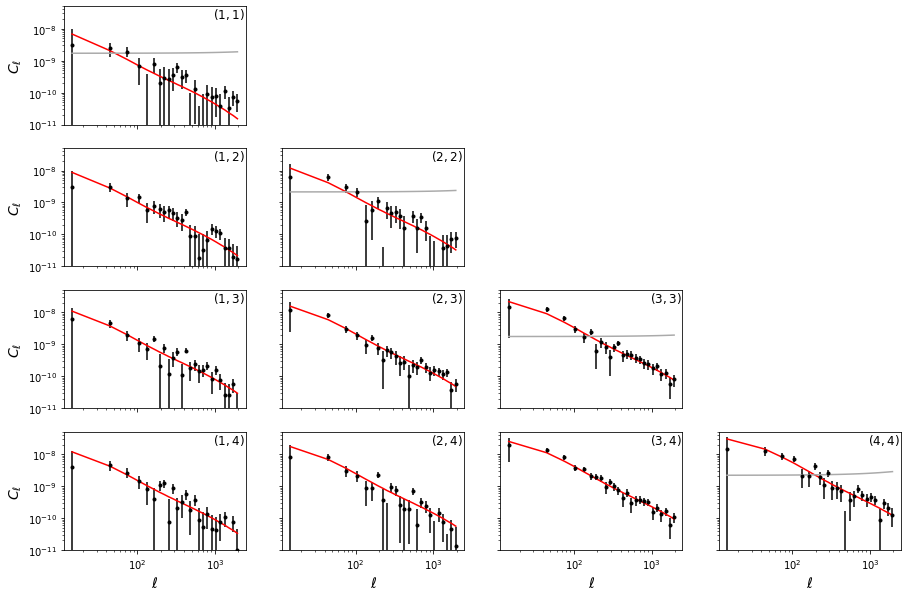

In [16]:
axes = get_triangle_axes()
errors = np.sqrt(np.diag(cov_full))
for n1, n2 in s.get_tracer_combinations():
    i1 = int(n1[-1])
    i2 = int(n2[-1])
    ax = axes[i2, i1]
    ind = s.indices(data_type='cl_ee',
                    tracers=(n1, n2))
    ell = s.get_tag('ell', data_type='cl_ee',
                    tracers=(n1, n2))
    dl = d[ind]
    el = errors[ind]
    tl = th[ind]
    ax.errorbar(ell, dl, yerr=el, fmt='k.')
    ax.plot(ell, tl, 'r-')
    # Noise here
    if i1 == i2:
        ax.plot(ell, s2.mean[ind], '-', c='#AAAAAA')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1E-11, 5E-8])
    ax.text(0.82, 0.9, f'$({i1+1},{i2+1})$',
            transform=ax.transAxes, fontsize=12)
    if i2 == 3:
        ax.set_xlabel(r'$\ell$', fontsize=14)
    if i1 == 0:
        ax.set_ylabel(r'$C_\ell$', fontsize=14)
plt.show()

## B-modes
We know $B$-modes are highly suppressed, so they should be consistent with zero. Let's check if that's the case!

We start by re-reading the data, but now removing all non-$BB$ correlations. To be even more stringent, we will consider an extended scale range here, using all $\ell<2N_{\rm side}=8192$.

In [17]:
sb = sacc.Sacc.load_fits('cls_signal_covG_ns4096.fits')
sb.remove_selection(data_type='cl_eb')
sb.remove_selection(data_type='cl_be')
sb.remove_selection(data_type='cl_ee')
sb.remove_selection(ell__gt=8192)

First let's plot them:

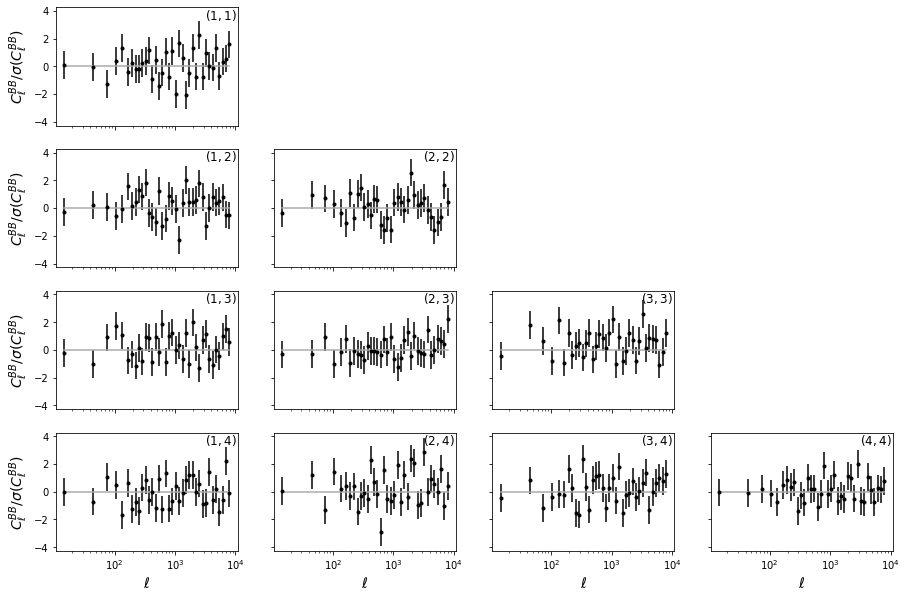

In [18]:
axes = get_triangle_axes()
errors = np.sqrt(np.diag(cov_full))
for n1, n2 in s.get_tracer_combinations():
    i1 = int(n1[-1])
    i2 = int(n2[-1])
    ax = axes[i2, i1]
    ell, cl, cv = sb.get_ell_cl('cl_bb', n1, n2, return_cov=True)
    el = np.sqrt(np.diag(cv))
    cl0 = np.zeros_like(cl)
    ax.errorbar(ell, cl/el, yerr=np.ones_like(cl), fmt='k.')
    ax.plot(ell, cl0, '-', c='#AAAAAA')
    ax.set_xscale('log')
    ax.text(0.82, 0.9, f'$({i1+1},{i2+1})$',
            transform=ax.transAxes, fontsize=12)
    if i2 == 3:
        ax.set_xlabel(r'$\ell$', fontsize=14)
    if i1 == 0:
        ax.set_ylabel(r'$C^{BB}_\ell/\sigma(C^{BB}_\ell)$',
                      fontsize=14)
plt.show()

OK, looks compatible with zero. Let's quantify that again through the $\chi^2$.

In [19]:
chi2 = np.dot(sb.mean, np.linalg.solve(sb.covariance.covmat, sb.mean))
ndof = len(sb.mean)
p = 1 - stats.chi2.cdf(chi2, ndof)
print("chi^2 = %.1lf, dof = %d, P = %.3lf" % (chi2, ndof, p))

chi^2 = 348.1, dof = 360, P = 0.664


Fantastic!